<h2 style="text-align: center; font-size: 24px;">
   ✨ <span style="color: #1E90FF;">Pion-Pion Scattering Energy Levels in a Finite Volume</span> 
    <br>
    <span style="color: #87CEFA;">using Lüscher's Quantisation Condition</span> ✨
</h2>


Our code is implementing a numerical solution to the Lüscher quantisation condition, which is used to extract finite-volume energy levels in a box of size L.

$m_\pi = 1$, finite box sizes from $0$ to $6$ in steps of $0.5$.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit  # just for speed
from scipy.interpolate import interp1d


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
m_pi = 1  # Pion mass (fix)

# Define L-values (Box Size) in fm
L_values = np.arange(0, 6.5, 0.5)  # L from 0 to 6 in steps of 0.5

# Define energy range with better precision
E_min, E_max, num_points = 0, 10 * m_pi, 2000  # Energy range from 0 to 10m_\pi(?) with 2000 points
E_values = np.linspace(E_min, E_max, num_points)

L_max = 80 #upper bound for summation over momenta
F = 1 # fix

Luscher Zeta function evaluated.

In [5]:
@njit
def norm_squared(x, y, z):
    """ Compute squared norm of a 3D vector (x,y,z). """
    return x*x + y*y + z*z

@njit
def Z_00(q2, L_max, epsilon=1e-8, l=0):  # Reduced epsilon for better accuracy  
    """ Compute Lüscher Zeta function Z_00 """
    Z_value = 0.0 + 0.0j

    for x in range(-L_max, L_max + 1):  
        for y in range(-L_max, L_max + 1):
            for z in range(-L_max, L_max + 1):
                r2 = norm_squared(x, y, z)
                if r2 >= L_max**2:
                    continue
                
                if r2 == 0 and abs(q2) >= 1e-12:
                    Z_value += (-1.0 / q2) * r2**(l / 2)
                    continue
                
                denominator = (r2 - q2) + epsilon * 1j
                Z_value += (r2**(l / 2)) / denominator

    return (Z_value.real - 4.*np.pi*L_max) / np.sqrt(4 * np.pi)


$Z_{00}(q^2) = \sum_{\mathbf{n} \neq 0} \frac{1}{|\mathbf{n}|^2 - q^2}$


In [6]:
@njit
def Z_00EL(E, L, L_max):
    """ Compute Z_00EL for given energy E and box size L """
    pSQ = (E**2 - 1) / 4
    qSQ = (L**2 * pSQ) / (4 * np.pi**2)
    return Z_00(qSQ, L_max)

@njit
def LHSEL(E, L, F=1):
    """ Compute left-hand side of the Luscher equation """
    pre = (np.sqrt(np.pi) * L) / 2
    M = (E**2 - m_pi**2) / F**2
    pcot = (16 * np.pi * E) / M
    return pre * pcot

@njit
def compute_D(E, L, L_max, F=1):
    """ Compute D(E, L) = Z_00EL(E, L) - LHSEL(E, L, F) """
    return Z_00EL(E, L, L_max) - LHSEL(E, L, F)




In [7]:
def get_energy_intersections(E_values, D_values, num_levels=20):  # Increased detected levels
    """ Find energy levels where D(E, L) = 0 using interpolation """
    sign_changes = np.where(np.diff(np.sign(D_values)))[0]
    intersections = []
    
    for i in sign_changes:
        E_low, E_high = E_values[i], E_values[i+1]
        D_low, D_high = D_values[i], D_values[i+1]
        slope = (E_high - E_low) / (D_high - D_low)
        E_intersection = E_low - slope * D_low
        intersections.append(E_intersection)

    return np.array(intersections)

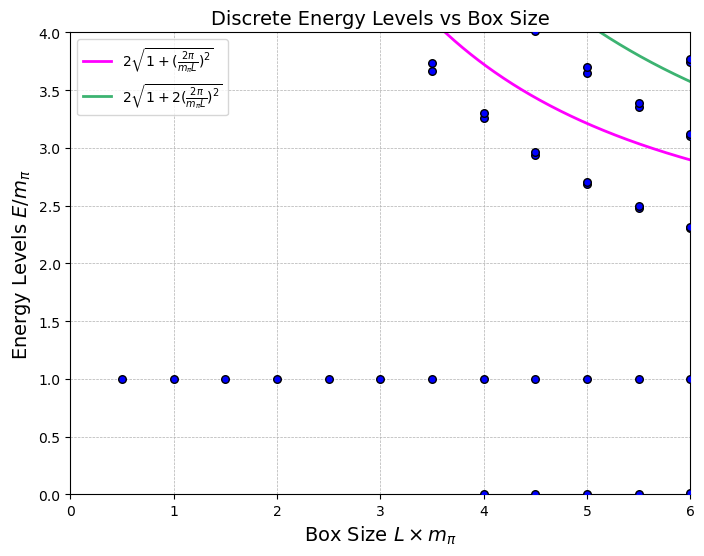

In [8]:
# Compute energy levels
all_energy_levels = []
for L in L_values:  # We loop over all box sizes L
    D_values = np.array([compute_D(E, L, L_max, F) for E in E_values])
    intersections = get_energy_intersections(E_values, D_values, num_levels=50)  # more
    all_energy_levels.append(intersections)  # discrete energy levels

all_energy_levels = np.array(all_energy_levels, dtype=object)

plt.figure(figsize=(8,6))

for level_idx in range(max(len(e) for e in all_energy_levels)): # removed smoothing
    L_filtered = []
    E_filtered = []
    
    for i, L in enumerate(L_values):
        if level_idx < len(all_energy_levels[i]):
            L_filtered.append(L)
            E_filtered.append(all_energy_levels[i][level_idx])

    if L_filtered:
        E_filtered = np.array(E_filtered) / m_pi
        L_filtered = np.array(L_filtered) * m_pi  

        # Scatter plot
        plt.scatter(L_filtered, E_filtered, color='blue', s=30, edgecolors='black', zorder=3)

## the analytical curves
L_smooth = np.linspace(0.5, 6, 500)  # more pts
E1 = 2 * np.sqrt(1 + (2 * np.pi / (m_pi * L_smooth))**2)
E2 = 2 * np.sqrt(1 + 2 * (2 * np.pi / (m_pi * L_smooth))**2)
plt.plot(L_smooth, E1, 'magenta', linewidth=2, label=r'$2\sqrt{1+( \frac{2\pi}{m_\pi L})^2}$')
plt.plot(L_smooth, E2, 'mediumseagreen', linewidth=2, label=r'$2\sqrt{1+2 (\frac{2 \pi}{m_\pi L})^2}$')
plt.legend()

plt.xlabel(r'Box Size $L \times m_{\pi}$', fontsize=14)
plt.ylabel(r'Energy Levels $E/m_{\pi}$', fontsize=14)
plt.title(r'Discrete Energy Levels vs Box Size', fontsize=14)

# plt.xlim(0, 6) 
#plt.xlim(0, max(L_filtered) * m_pi)  # Adjust dynamically
plt.xlim(0, 6)  # Fix x-axis to range from 0 to 6
 
plt.ylim(0, 4)


plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()



Differences between Computed and Theoretical Energy Levels:
       L  Computed E  Difference (Magenta)  Difference (Green)
0    0.5    0.995999             24.216194           34.603290
1    1.0    0.995998             11.728532           16.887719
2    1.5    0.995997              7.617008           11.019314
3    1.5    7.718256              0.894749            4.297056
4    1.5    8.436377              0.176628            3.578934
..   ...         ...                   ...                 ...
187  6.0    9.414761              6.518817            5.840830
188  6.0    9.575288              6.679344            6.001357
189  6.0    9.644960              6.749017            6.071030
190  6.0    9.841016              6.945072            6.267085
191  6.0    9.870450              6.974506            6.296519

[192 rows x 4 columns]


/var/folders/k6/tjn5pj4d7z9d29567xbyxl240000gn/T/ipykernel_3789/2849106506.py:2: RuntimeWarning: divide by zero encountered in true_divide
  E_theory_magenta = 2 * np.sqrt(1 + (2 * np.pi / (m_pi * L_values))**2)
/var/folders/k6/tjn5pj4d7z9d29567xbyxl240000gn/T/ipykernel_3789/2849106506.py:3: RuntimeWarning: divide by zero encountered in true_divide
  E_theory_green = 2 * np.sqrt(1 + 2 * (2 * np.pi / (m_pi * L_values))**2)


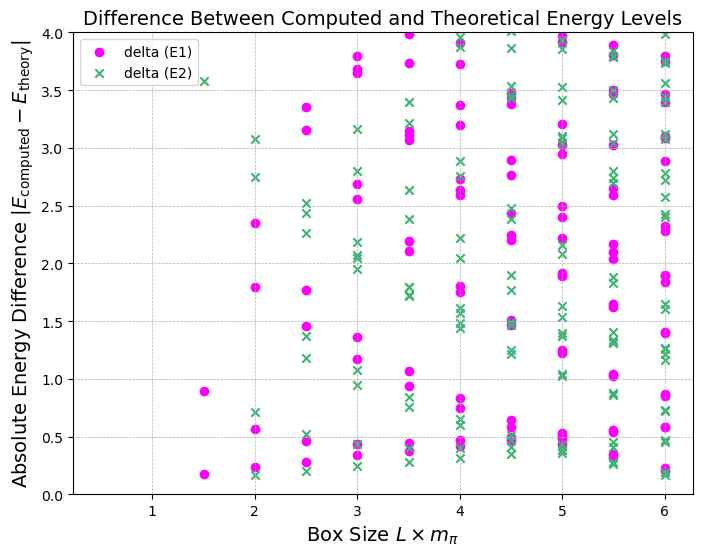

In [ ]:
E1_theory = 2 * np.sqrt(1 + (2 * np.pi / (m_pi * L_values))**2)
E2_theory = 2 * np.sqrt(1 + 2 * (2 * np.pi / (m_pi * L_values))**2)

differences = []

# Iterate over energy levels
for i, L in enumerate(L_values):
    energy_levels = all_energy_levels[i]
    
    if len(energy_levels) > 0:  # Only process non-empty levels
        for E in energy_levels:  
            diff_magenta = abs(E - E1_theory[i])
            diff_green = abs(E - E2_theory[i])
            differences.append((L, E, diff_magenta, diff_green))

# DataFrame
df_differences = pd.DataFrame(differences, columns=["L", "Computed E", "Difference (Magenta)", "Difference (Green)"])

print("\nDifferences between Computed and Theoretical Energy Levels:")
print(df_differences)

plt.figure(figsize=(8,6))
plt.scatter(df_differences["L"], df_differences["Difference (E1)"], color='magenta', label="delta (E1)", marker='o')
plt.scatter(df_differences["L"], df_differences["Difference (E2)"], color='mediumseagreen', label="delta (E2)", marker='x')
plt.ylim(0, 4)
plt.xlabel(r'Box Size $L \times m_{\pi}$', fontsize=14)
plt.ylabel(r'Absolute Energy Difference $|E_{\mathrm{computed}} - E_{\mathrm{theory}}|$', fontsize=14)
plt.title("Difference Between Computed and Theoretical Energy Levels", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


We will now find the difference between the analytic function and the numerically computed values.

In [ ]:
print("Updated computed energy levels per L:", [len(levels) for levels in all_energy_levels])

In [ ]:
print("L_values range:", L_values[0], "to", L_values[-1])
print("Computed energy levels per L:", [len(levels) for levels in all_energy_levels])


In [16]:
# Print L_values
print("L_values =", list(L_values))

# Print all_energy_levels
print("all_energy_levels =", [list(levels) for levels in all_energy_levels])


L_values = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]
all_energy_levels = [[], [0.9959988190877501], [0.9959978695173525], [0.9959972532509263, 7.718255824210898, 8.436377273582947], [0.9959970062400275, 6.030753560485305, 6.35908528594159, 8.39363346032592, 8.942073977431987], [0.995996908958446, 4.950512086372485, 5.12503629543908, 6.864484609418089, 7.183575529552711, 8.565583386292047, 8.760266163464365, 9.907667486649085], [0.9959968679141482, 4.205104532350869, 4.302775184309103, 5.815676737357607, 6.003341927059707, 7.200013249126208, 7.328532132261265, 8.32134347812459, 8.436337147079767, 9.055601767646877, 9.414766061492832], [0.9959968496732171, 3.6636701676093004, 3.731664079081725, 5.051026904187482, 5.175011103307242, 6.217359564015665, 6.302645350529303, 7.1772921379301895, 7.252105743378363, 7.841851093017443, 8.09267631846329, 8.67577332971635, 8.852525204048549], [0.0012466577307205086, 0.9959968415017505, 3.2550267691033237, 3.3013619042107796, 